<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/HonGong_ML_DL/19_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM과 GRU 셀

### **키워드:**  LSTM, 셀 상태, GRU

순환 신경망에서 빼놓을 수 없는 핵심 기술인 LSTM과 GRU 셀을 사용한 모델을 만들어보자.

일반적으로 기본 순환층은 긴 시퀀스를 학습하기 어렵다. 시퀀스가 길수록 순환되는 은닉 상태에 담긴 정보가 점차 희석되기 때문에 멀리 떨어져 있는 단어 정보를 인식하는데 어려움이 있다.

이를 해결하기 위해 LSTM과 GRU 셀이 발명되었다.

In [1]:
# packages

from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## LSTM 구조

LSTM은 Long Shor-Term Memory의 약자로, 단기 기억을 오래 기억하기 위해 고안된 구조이다. LSTM에는 입력과 가중치를 곤하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가지고 있다. 이런 계산 결과는 다음 타임스텝에 재사용된다.

입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시킨 값을 다음 은닉 상태를 만들기 위해 사용한다. 이때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용한다. 여기에 tanh 활성화 함수를 통과한 어떤 값을 곱해 은닉 상태를 만든다. 여기서의 어떤 값은 셀 상태로부터 만들어진 은닉 상태이다.

LSTM에는 순환되는 상태는 은닉 상태와 셀 상태(cell state)로 2개이다. 은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값이다. 입력과 은닉 상태를 첫 번째 가중치와는 다른 가중치에 곱하여 시그모이드 함수를 통과시킨 후 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다. 이 셀 상태가 tanh 함수를 통과하여 새로운 은닉 상태를 만드는데 기여한다.

여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는 데 기여한다. 이전과 마찬가지로 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, 하나의 시그모이드 함수를 통과시키고 다른 하나는 tanh 함수를 통과시킨다. 그 다음 두 결과를 곱하여 이전 셀 상태와 더하면 최종적인 다음 셀 상태가 된다.

<img src='https://user-images.githubusercontent.com/76294398/147720072-4a3a011f-5ccb-4c83-bc5b-518cc33c5b26.png' width=40% height=80%>


삭제 게이트(forget gate)는 셀 상태에 있는 정보를 제거하는 역할을 하고 입력 게이트(input gate)는 새로운 정보를 셀 상태에 추가한다. 출력 게이트(output gate)를 통해서 이 셀 상태가 다음 은닉 상태로 출력된다.

## LSTM 신경망 훈련하기

In [2]:
# dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=500)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_seq = pad_sequences(X_train, maxlen=100)
val_seq = pad_sequences(X_val, maxlen=100)

17473536/17464789 [==============================] - 0s 0us/step


In [3]:
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


LSTM에는 작은 셀이 4개가 있으므로 SimpleRNN 대비 모델 파라미터 개수가 4배 늘어 800개가 되었다.

In [4]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 15s 41ms/step - loss: 0.6922 - accuracy: 0.5465 - val_loss: 0.6910 - val_accuracy: 0.5808
Epoch 2/100
313/313 [==============================] - 14s 45ms/step - loss: 0.6884 - accuracy: 0.6234 - val_loss: 0.6856 - val_accuracy: 0.6328
Epoch 3/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6775 - accuracy: 0.6619 - val_loss: 0.6663 - val_accuracy: 0.6430
Epoch 4/100
313/313 [==============================] - 11s 36ms/step - loss: 0.6298 - accuracy: 0.7058 - val_loss: 0.6064 - val_accuracy: 0.7304
Epoch 5/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5885 - accuracy: 0.7397 - val_loss: 0.5828 - val_accuracy: 0.7440
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.5663 - accuracy: 0.7539 - val_loss: 0.5622 - val_accuracy: 0.7534
Epoch 7/100
313/313 [==============================] - 11s 36ms/step - loss: 0.5473 - accuracy: 0.7624 - val_loss: 0.5451 - val_ac

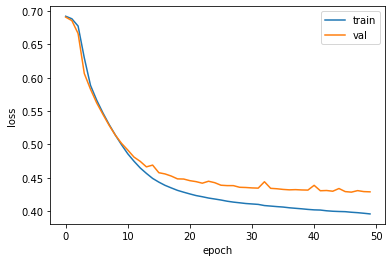

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

기본 순환층보다 확실히 과대적합을 잘 억제하고 있다. 하지만 경우에 따라서는 더 강하게 억제할 필요가 있다. 드롭아웃으로 이를 수행해보자.

## 순환층에 드롭아웃 적용하기

기존에는 Dropout 클래스를 사용하여 드롭아웃을 적용했다. 반면 순환층은 자체적으로 드롭아웃 기능을 제공한다.

dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고 recurrent_dropout 매개변수는 순환되는 은닉 상태에 드롭아웃을 적용한다.(기술적인 문제로 recurrent_dropout은 GPU를 사용하지 못한다.)

In [6]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 17s 47ms/step - loss: 0.6925 - accuracy: 0.5264 - val_loss: 0.6917 - val_accuracy: 0.5716
Epoch 2/100
313/313 [==============================] - 12s 38ms/step - loss: 0.6904 - accuracy: 0.5901 - val_loss: 0.6886 - val_accuracy: 0.6160
Epoch 3/100
313/313 [==============================] - 12s 39ms/step - loss: 0.6846 - accuracy: 0.6362 - val_loss: 0.6795 - val_accuracy: 0.6562
Epoch 4/100
313/313 [==============================] - 12s 39ms/step - loss: 0.6606 - accuracy: 0.6623 - val_loss: 0.6321 - val_accuracy: 0.6858
Epoch 5/100
313/313 [==============================] - 12s 37ms/step - loss: 0.6031 - accuracy: 0.7178 - val_loss: 0.5890 - val_accuracy: 0.7246
Epoch 6/100
313/313 [==============================] - 13s 41ms/step - loss: 0.5751 - accuracy: 0.7341 - val_loss: 0.5656 - val_accuracy: 0.7394
Epoch 7/100
313/313 [==============================] - 12s 39ms/step - loss: 0.5524 - accuracy: 0.7490 - val_loss: 0.5435 - val_ac

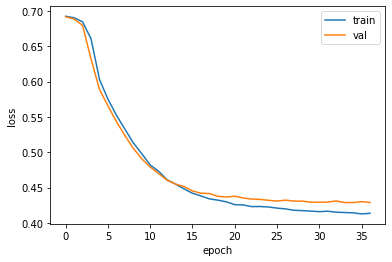

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

LSTM 층에 적용된 드롭아웃이 효과를 발휘해 훈련 손실과 검증 손실 간 차이가 좁혀졌다.

이번에는 2개의 순환층을 연결한 모델을 훈련해보자.